## Tensorflow进行数据分析
简单介绍了Tensorflow深度学习框架的运算流程之后，引入一个具体案例，并使用Tensorflow对数据进行 分析。

在数据分类的研究中，普遍存在类别分布不平衡的问题，即某一类别的样本数量远远多于另一类，具有这样特征的数据集视为不平衡。  
我们将使用Kaggle 上托管的 Credit Card Fraud Detection 数据集，目的是从总共 284,807 笔交易中检测出仅有的 492 笔欺诈交易。  
我们需要做的就是定义模型和类权重，从而帮助模型从不平衡数据中学习。

具体流程：
* 使用 Pandas 加载 CSV 文件。
* 创建训练、验证和测试集。
* 训练模型（包括设置类权重）。
* 使用各种指标（包括精确率和召回率）评估模型。
* 尝试使用常见技术来处理不平衡数据，例如：类加权

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 控制图像属性
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### 数据处理与浏览

In [10]:
# 下载 Kaggle Credit Card Fraud 数据集
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
# 对数据属性进行描述
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
# 检查数据集的不平衡情况
neg, pos = np.bincount(raw_df['Class']) # 同Class属性对数据进行分析
total = neg + pos #这里我们将欺诈数量作为正样本pos
print('Examples:\n    总计: {}\n    欺诈交易数量: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    总计: 284807
    欺诈交易数量: 492 (0.17% of total)



### 清理、拆分和归一化数据
原始数据有一些问题。首先，Time 和 Amount 列变化太大，无法直接使用。删除 Time 列（因为不清楚其含义），并获取 Amount 列的日志以缩小其范围。

In [11]:
cleaned_df = raw_df.copy()

# 删除Time列
cleaned_df.pop('Time')

# 获取 Amount 列的日志以缩小其范围
eps=0.001
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

将数据集拆分为训练、验证和测试集。验证集在模型拟合期间使用，用于评估损失和任何指标，判断模型与数据的拟合程度。测试集在训练阶段完全不使用，仅在最后用于评估模型泛化到新数据的能力。这对于不平衡的数据集尤为重要，因为过拟合是缺乏训练数据造成的一个重大问题。

In [14]:
# 拆分为训练、验证和测试集
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# 形成标签和特征的np数组
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)
print(train_features)

[[-1.42048887e+00  1.09880362e+00  1.63835847e+00 ... -1.72045796e-01
  -1.39209006e-01  2.54952329e+00]
 [ 1.91977743e+00 -5.15399093e-01 -9.20753660e-01 ... -6.21946913e-02
  -4.38767141e-02  4.19057856e+00]
 [-1.24128622e+00  1.10901088e+00  1.04311024e+00 ...  4.68305582e-01
   1.96301942e-01  3.97031078e+00]
 ...
 [ 1.20486003e+00 -6.64091980e-03 -3.74094819e-01 ... -6.14565309e-03
   1.49813518e-03  4.08934877e+00]
 [ 1.49671679e+00 -6.95956491e-01  1.85339914e-01 ...  1.64507476e-02
   4.50199392e-03  1.79192612e+00]
 [ 1.11645056e+00 -8.78775630e-01 -1.44111798e+00 ...  1.35149531e-02
   4.48778434e-02  5.05650692e+00]]


In [13]:
# 使用 sklearn StandardScaler 将输入特征归一化（平均值设置为 0，标准偏差设置为 1）
scaler = StandardScaler()
# 使用 train_features 进行拟合，以确保模型不会窥视验证集或测试集
train_features = scaler.fit_transform(train_features) 

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# np.clip为截取函数，截取大于-5小于5的数
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### 查看数据分布


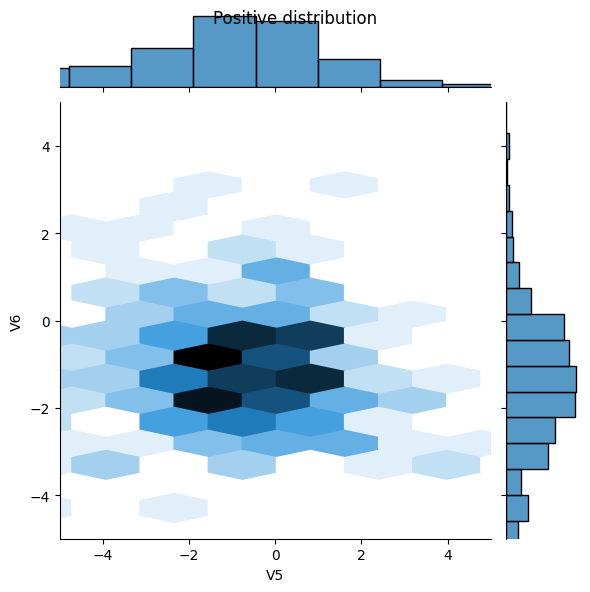

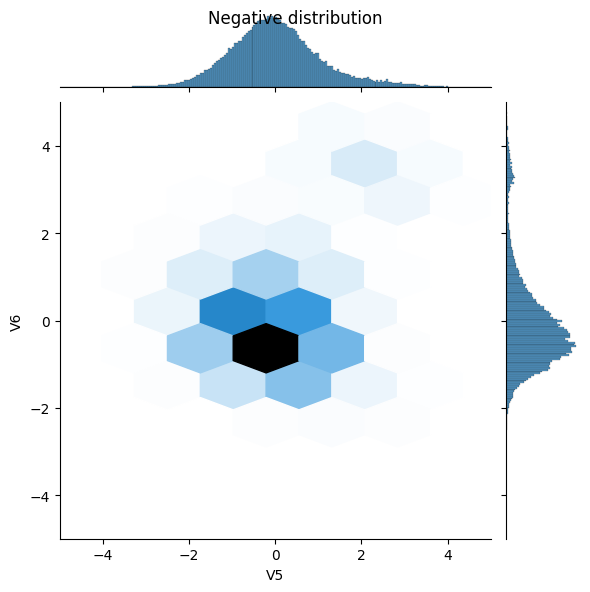

In [15]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

### 定义模型和指标
定义一个函数，该函数会创建一个简单的神经网络，其中包含一个密集连接的隐藏层、一个用于减少过拟合的随机失活层，以及一个返回欺诈交易概率的输出 Sigmoid 层：

In [16]:
# 指标
METRICS = [
      keras.metrics.TruePositives(name='tp'), # 真正例
      keras.metrics.FalsePositives(name='fp'),  # 假正例
      keras.metrics.TrueNegatives(name='tn'), # 真负例
      keras.metrics.FalseNegatives(name='fn'), # 假负例
      keras.metrics.BinaryAccuracy(name='accuracy'), # 准确率是被正确分类的样本的百分比
      keras.metrics.Precision(name='precision'), # 精确率是被正确分类的预测正例的百分比
      keras.metrics.Recall(name='recall'),  # 召回率是被正确分类的实际正例的百分比
      keras.metrics.AUC(name='auc'), # AUC 是指接收器操作特征曲线中的曲线下方面积 (ROC-AUC)。此指标等于分类器对随机正样本的排序高于随机负样本的概率。
      keras.metrics.AUC(name='prc', curve='PR'), # AUPRC 是指精确率-召回率曲线下方面积。该指标计算不同概率阈值的精度率-召回率对。
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)), # 隐藏层
      keras.layers.Dropout(0.5), # 随机失活层
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias), # sigmoid层
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3), # 优化器
      loss=keras.losses.BinaryCrossentropy(), # 损失
      metrics=metrics) # 指标

  return model

### 基线模型
注：此模型无法很好地处理类不平衡问题。我们将在本教程的后面部分对此进行改进。

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

# 早停机制
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


### 训练模型


In [22]:
model = make_model()
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 13ms/step - loss: 1.1795 - tp: 323.0000 - fp: 120843.0000 - tn: 106608.0000 - fn: 71.0000 - accuracy: 0.4693 - precision: 0.0027 - recall: 0.8198 - auc: 0.7785 - prc: 0.0194 - val_loss: 0.6323 - val_tp: 71.0000 - val_fp: 14543.0000 - val_tn: 30948.0000 - val_fn: 7.0000 - val_accuracy: 0.6807 - val_precision: 0.0049 - val_recall: 0.9103 - val_auc: 0.9164 - val_prc: 0.2200
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.5103 - tp: 204.0000 - fp: 46936.0000 - tn: 135024.0000 - fn: 112.0000 - accuracy: 0.7419 - precision: 0.0043 - recall: 0.6456 - auc: 0.7448 - prc: 0.0607 - val_loss: 0.2624 - val_tp: 50.0000 - val_fp: 938.0000 - val_tn: 44553.0000 - val_fn: 28.0000 - val_accuracy: 0.9788 - val_precision: 0.0506 - val_recall: 0.6410 - val_auc: 0.8897 - val_prc: 0.3038
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.2800 - tp: 160.0000 - fp: 16609.0000 - tn: 165351.0000 - fn: 156.00

### 查看训练历史记录
针对训练集和验证集生成模型的准确率和损失绘图。检查是否过拟合。

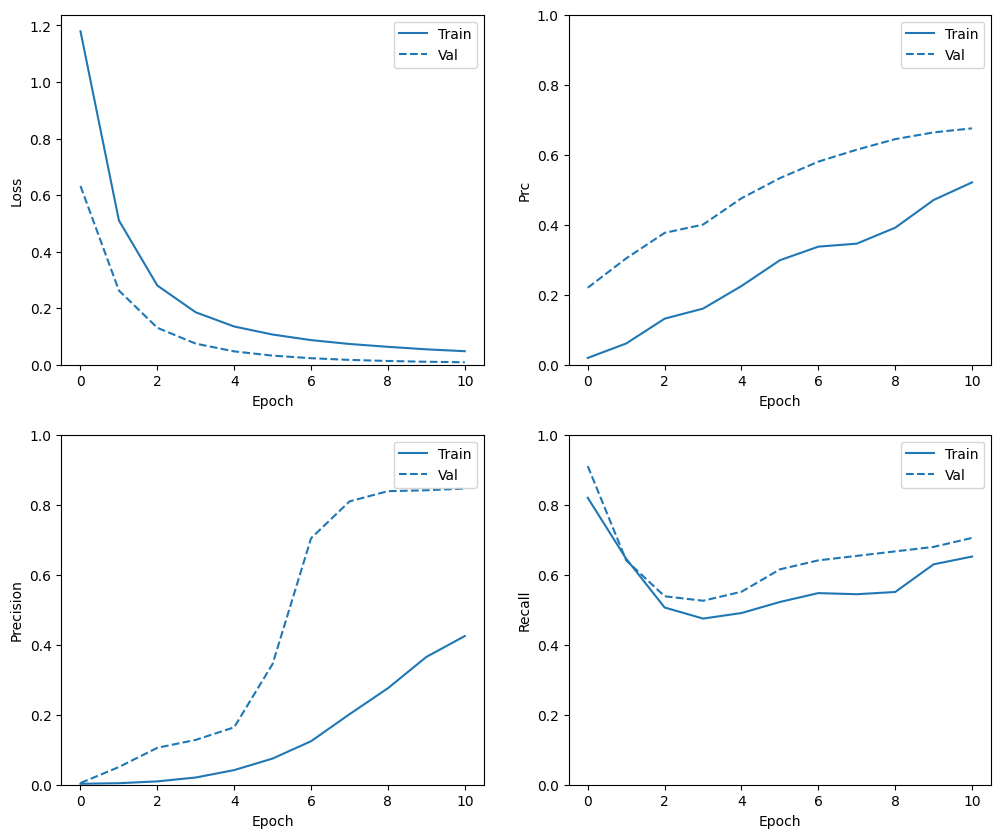

In [23]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

# 可视化
plot_metrics(baseline_history)

loss :  0.6309481859207153
tp :  85.0
fp :  17927.0
tn :  38937.0
fn :  13.0
accuracy :  0.6850531697273254
precision :  0.004719076212495565
recall :  0.8673469424247742
auc :  0.8840129971504211
prc :  0.15706372261047363

Legitimate Transactions Detected (True Negatives):  38937
Legitimate Transactions Incorrectly Detected (False Positives):  17927
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  98


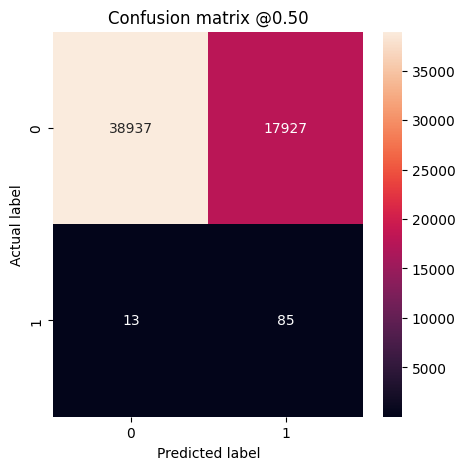

In [26]:
# 评估指标
# 使用混淆矩阵来汇总实际标签与预测标签，其中 X 轴是预测标签，Y 轴是实际标签
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

如果模型完美地预测了所有内容，则这是一个对角矩阵，其中偏离主对角线的值（表示不正确的预测）将为零。在这种情况下，矩阵会显示假正例相对较少，这意味着被错误标记的合法交易相对较少。但是，我们可能希望得到更少的假负例，即使这会增加假正例的数量。这种权衡可能更加可取，因为假负例允许进行欺诈交易，而假正例可能导致向客户发送电子邮件，要求他们验证自己的信用卡活动。

### 绘制ROC
ROC绘图非常有用，因为它一目了然地显示了模型只需通过调整输出阈值就能达到的性能范围。

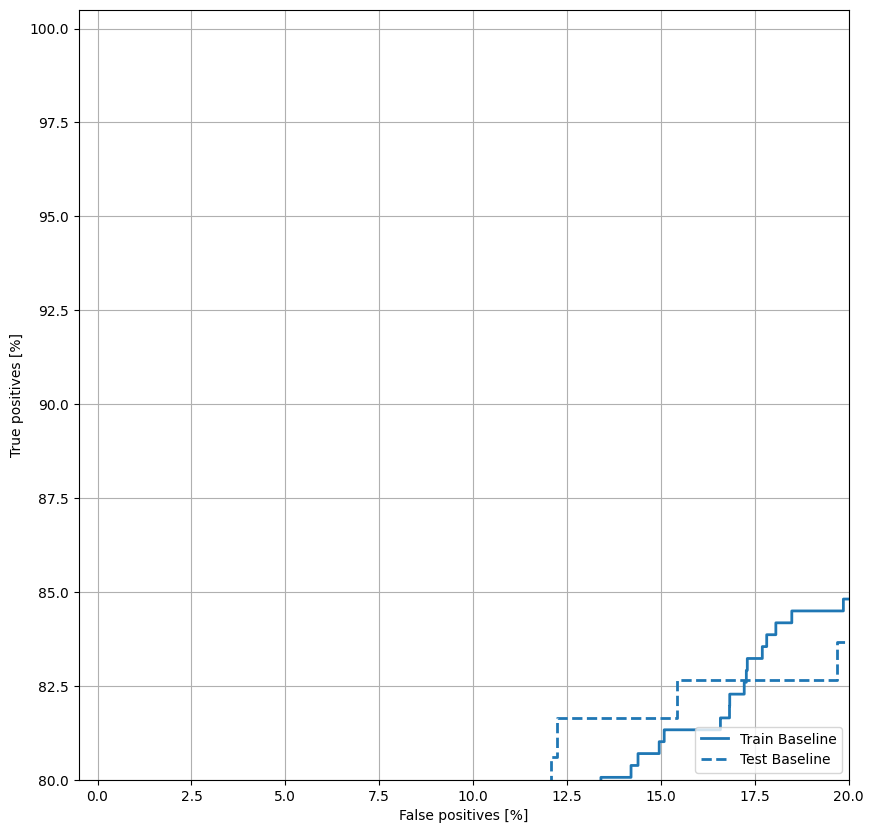

In [28]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### 绘制 AUPRC
内插精确率-召回率曲线的下方面积，通过为分类阈值的不同值绘制（召回率、精确率）点获得。根据计算方式，PR AUC 可能相当于模型的平均精确率。

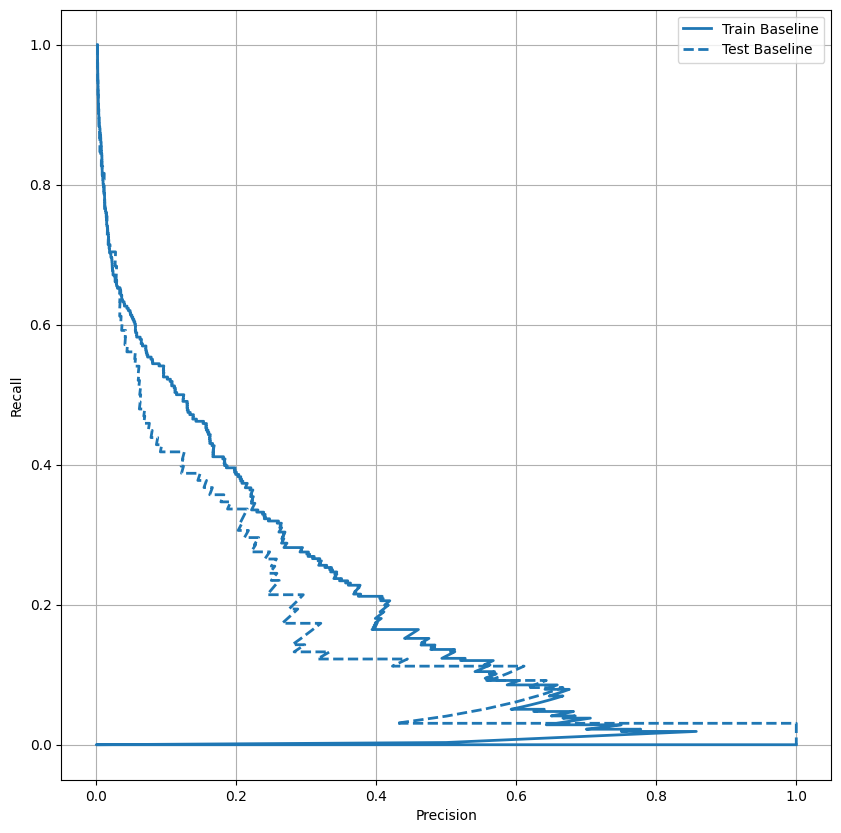

In [37]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend();

假负例（漏掉欺诈交易）可能造成财务损失，而假正例（将交易错误地标记为欺诈）则可能降低用户满意度。

## 类权重
我们的目标是识别欺诈交易，但没有很多可以使用的此类正样本，因此希望分类器提高可用的少数样本的权重。为此，可以使用参数将 Keras 权重传递给每个类。这些权重将使模型“更加关注”来自代表不足的类的样本。

In [30]:
# 按total/2进行缩放有助于将损失保持在相似的量级
# 所有例子的权重之和保持不变
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### 使用类权重训练模型


In [31]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # 使用 class_weights 会改变损失范围。这可能会影响训练的稳定性，具体取决于优化器
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
90/90 [==============================] - 3s 13ms/step - loss: 0.7281 - tp: 380.0000 - fp: 147173.0000 - tn: 91651.0000 - fn: 34.0000 - accuracy: 0.3847 - precision: 0.0026 - recall: 0.9179 - auc: 0.8390 - prc: 0.0371 - val_loss: 0.8372 - val_tp: 75.0000 - val_fp: 24519.0000 - val_tn: 20972.0000 - val_fn: 3.0000 - val_accuracy: 0.4619 - val_precision: 0.0030 - val_recall: 0.9615 - val_auc: 0.9530 - val_prc: 0.4755
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.4368 - tp: 293.0000 - fp: 72103.0000 - tn: 109857.0000 - fn: 23.0000 - accuracy: 0.6043 - precision: 0.0040 - recall: 0.9272 - auc: 0.9238 - prc: 0.2344 - val_loss: 0.4927 - val_tp: 71.0000 - val_fp: 7618.0000 - val_tn: 37873.0000 - val_fn: 7.0000 - val_accuracy: 0.8327 - val_precision: 0.0092 - val_recall: 0.9103 - val_auc: 0.9585 - val_prc: 0.6459
Epoch 

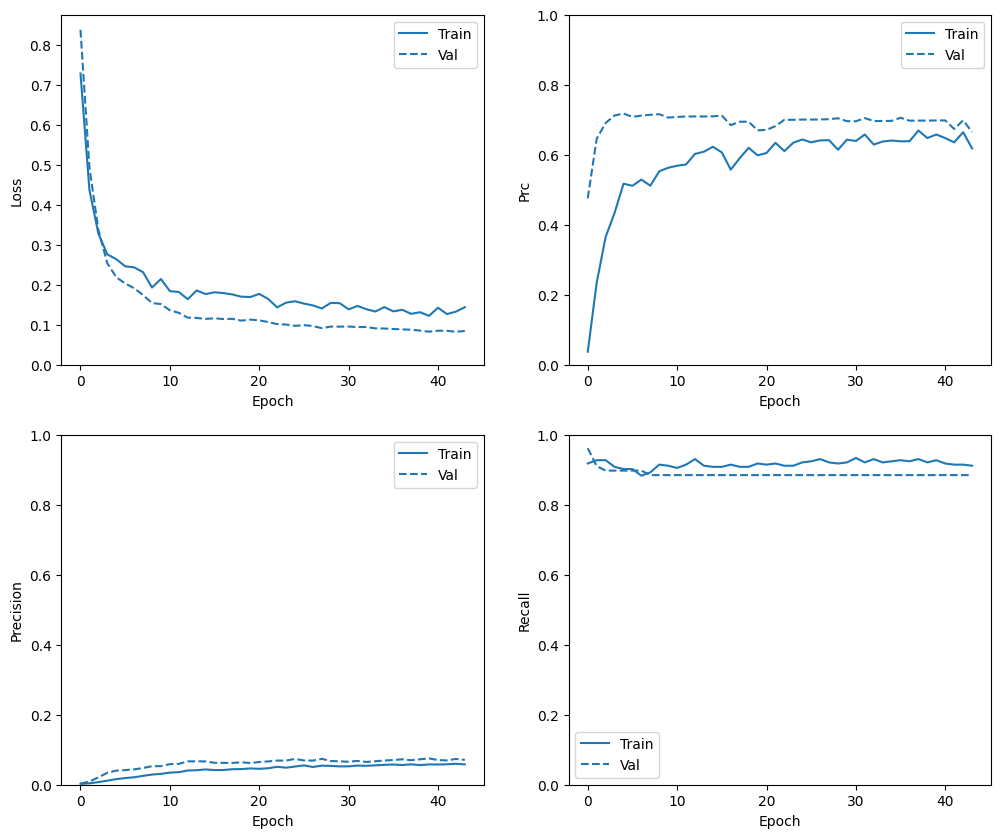

In [32]:
# 查看训练历史记录
plot_metrics(weighted_history)

loss :  0.0886046513915062
tp :  89.0
fp :  1128.0
tn :  55736.0
fn :  9.0
accuracy :  0.9800392985343933
precision :  0.07313065230846405
recall :  0.9081632494926453
auc :  0.9855610132217407
prc :  0.6803525686264038

Legitimate Transactions Detected (True Negatives):  55736
Legitimate Transactions Incorrectly Detected (False Positives):  1128
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  98


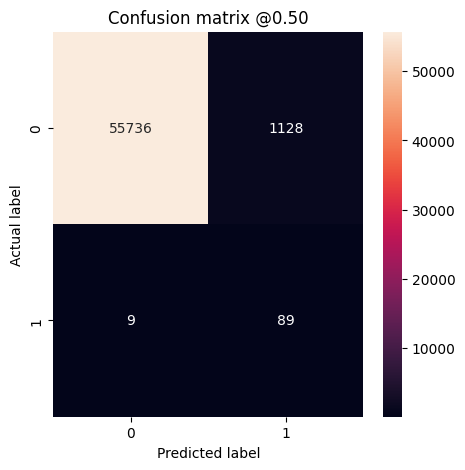

In [33]:
# 评估指标
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

在这里，我们可以看到，使用类权重时，由于存在更多假正例，准确率和精确率较低，但是相反，由于模型也找到了更多真正例，召回率和 AUC 较高。尽管准确率较低，但是此模型具有较高的召回率（且识别出了更多欺诈交易）。当然，两种类型的错误都有代价（客户也不希望因将过多合法交易标记为欺诈来打扰客户）。请在应用时认真权衡这些不同类型的错误。

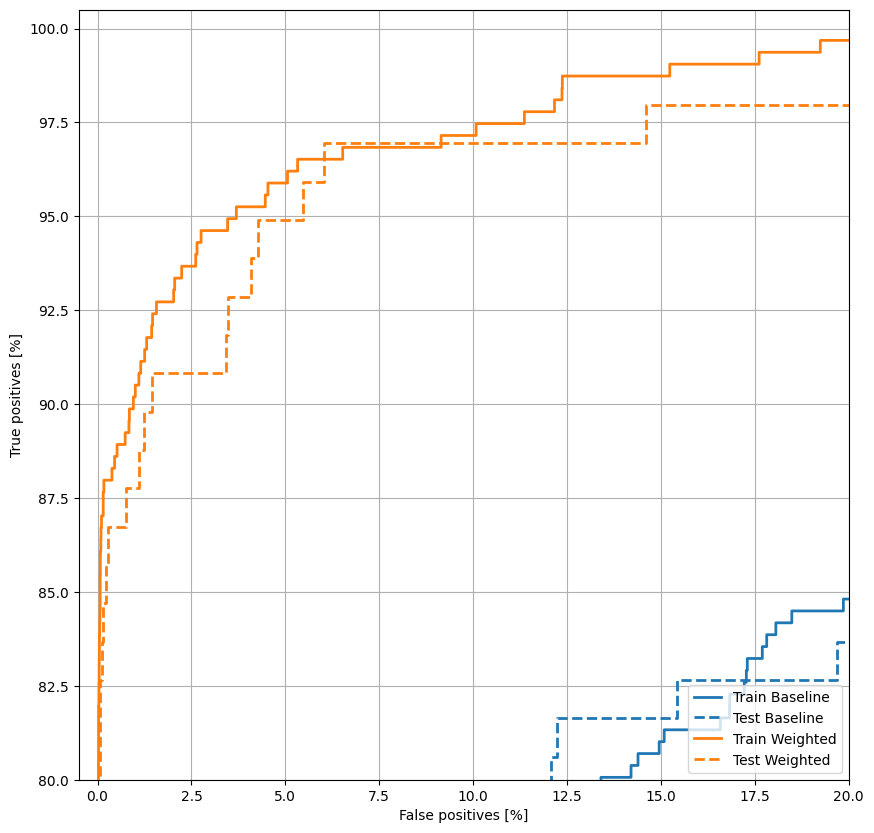

In [34]:
# 绘制ROC
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

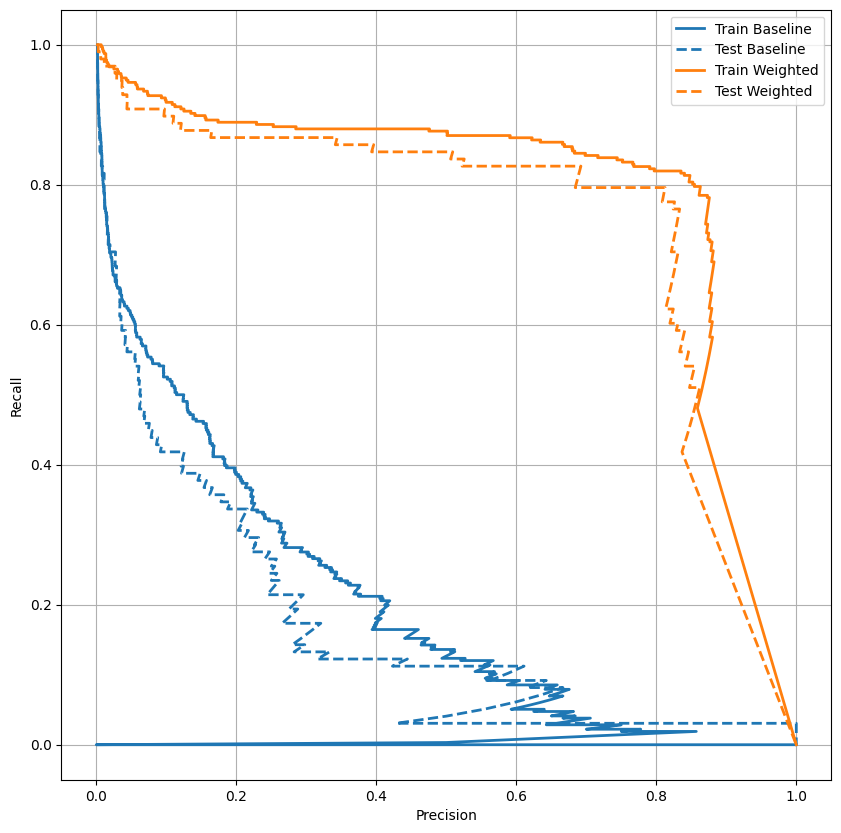

In [36]:
# 绘制AUPRC
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend();

## 总结
由于可供学习的样本过少，不平衡数据的分类是固有难题。我们应该始终先从数据开始，尽可能多地收集样本，并充分考虑可能相关的特征，以便模型能够充分利用占少数的类。有时我们的模型可能难以改善且无法获得想要的结果，因此请务必牢记问题的上下文，并在不同类型的错误之间进行权衡。